In [3]:
import kagglehub
path = kagglehub.dataset_download('abhi8923shriv/sentiment-analysis-dataset')

print('Data source import complete.')


100%|██████████| 54.4M/54.4M [00:00<00:00, 174MB/s]

Extracting files...


Data source import complete.


# Sentiment Analysis on Kaggle sentiment analysis dataset
sentiment analysis tasks on kaggle sentiment analysis dataset using simple machine learning model: Naive bayes


## Including needed libraries

In [4]:
pip install torchmetrics

  Using cached torchmetrics-1.6.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.12.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.wh

In [5]:
# --------------- MAIN LIBRARIES ------------------

import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords


# --------------- HELPING LIBRARIES ----------------
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linear_sum_assignment


# ------------- Pytorch Librairies ---------------
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModelForCausalLM, pipeline
from peft import LoraConfig, get_peft_model, TaskType
import torch.nn.functional as F
from torchmetrics.classification import MulticlassF1Score

# ------------- Sckikit Learn Librairies ---------------
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans, DBSCAN



## Uploading Data

In [ ]:
train_dataset = path+'/train.csv'
test_dataset = path+'/test.csv'

# Check if the path exists
print (os.path.exists(train_dataset))
print (os.path.exists(test_dataset))

In [ ]:
# Load the CSV file into a DataFrame
train_df = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_df = pd.read_csv(test_dataset, encoding='ISO-8859-1')


In [ ]:
train_df.head()

## Data Preprocessing

In [ ]:
train_df.info()

In [ ]:
test_df.info()

#### Handling null values

In [ ]:
train_df.isnull().sum()

In [ ]:
train_df = train_df.dropna()
train_df.isnull().sum()

In [ ]:
test_df.isnull().sum()

In [ ]:
test_df = test_df.dropna()
test_df.isnull().sum()

#### Removing stopwords & lowercase all text

In [ ]:
# Download necessary NLTK data
nltk.download('stopwords')

In [ ]:
# Text preprocessing function that removes stopwords and convert text to lowercase

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text



In [ ]:
# Apply preprocessing on train dataset
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
train_df.head()

In [ ]:
# Apply preprocessing on train dataset
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
test_df.head()

## Check Imbalancing

In [ ]:
# Distribution of sentiment labels
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution of Sentiment Labels")
plt.show()

In [ ]:
# 1. Transform sentiment into 3 classes
# Example mapping: positive -> 2, neutral -> 1, negative -> 0
sentiment_mapping = {"positive": 2, "neutral": 1, "negative": 0}
train_df["sentiment_class"] = train_df["sentiment"].map(sentiment_mapping)
test_df["sentiment_class"] = test_df["sentiment"].map(sentiment_mapping)

# 2. Extract all the values from the 'processed_text' column into a list
trainval_x = train_df["processed_text"].tolist()
trainval_y = train_df["sentiment_class"].tolist()

train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, test_size=0.25, random_state=42)

test_x = test_df["processed_text"].tolist()
test_y = test_df["sentiment_class"].tolist()

In [ ]:
print(len(trainval_x),len(val_x),len(test_x))

In [ ]:
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 64
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Extract embeddings for all data
def extract_embeddings(model, dataloader, device):
    """
    Extracts embeddings for all data using a pre-trained BERT model.

    Args:
        model (transformers.BertModel): Pre-trained BERT model.
        dataloader (DataLoader): DataLoader for the dataset.
        device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
        torch.Tensor: A matrix of size (number_of_samples, embedding_size).
    """
    model.eval()  # Set the model to evaluation mode
    embeddings = []

    with torch.no_grad():  # Disable gradient computation
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            # Forward pass through BERT
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            pooled_output = outputs.pooler_output  # CLS token representation

            # Append embeddings to the list
            embeddings.append(pooled_output.cpu())

    # Combine all embeddings into a single matrix
    return torch.cat(embeddings, dim=0)

# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(train_x, train_y, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(val_x, val_y, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings = train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings = val_embeddings.cpu()


In [ ]:
print(train_embeddings.size())
print(val_embeddings.size())


In [ ]:
criterion = nn.CrossEntropyLoss()

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Custom Dataset
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        """
        Args:
            texts (list): List of text samples.
            labels (list): List of sentiment labels (e.g., 0, 1).
            tokenizer (transformers.BertTokenizer): Tokenizer for BERT.
            max_length (int): Maximum length for tokenized sequences.
        """
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        # Tokenize and encode the text
        embeddings = self.embeddings[idx]
        label = self.labels[idx]

        return {
            "input_ids": embeddings.squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

# Model Definition
class SentimentClassifier(nn.Module):
    def __init__(self, hidden_size, num_classes):
        super(SentimentClassifier, self).__init__()

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids):

        # Pass through the fully connected layer
        logits = self.fc(input_ids)
        return logits

# training script

def train( model, train_loader, optimizer, epoch,log_interval=50):
    model.train()
    loss_cpu=0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader, 0):

        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()
        inputs =inputs.detach()

        optimizer.zero_grad()  # Reset gradients


        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu += loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

# testing script
def test( model, test_loader, epoch):
    model.eval()
    correct = 0
    total = 0
    test_loss_MSE =0
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'],data['label']
            inputs, target = inputs.cuda(), target.cuda()
            outputs  = model(inputs)
            loss = criterion(outputs,target)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()
            test_loss_MSE+= loss.item()

    test_loss_MSE = test_loss_MSE/ len(test_loader)
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%%" %(epoch, loss.item(), 100.*correct/total))
    return test_loss_MSE, 100.*correct/total

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 128
NUM_CLASSES = 3
LEARNING_RATE = 1e-3
EPOCHS = 50
hidden_size = 768
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print ("Let us Train.")


model = SentimentClassifier(hidden_size, NUM_CLASSES).to(device)
model_test = SentimentClassifier(hidden_size, NUM_CLASSES).to(device)

traindataset = EmbeddingDataset(train_embeddings, train_y)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, val_y)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)


optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=8)

best_error = float('inf')
train_history = []
val_history = []
print('----------------------------------------------------------------------------------------------------')
print('3/ training model 1')
print('----------------------------------------------------------------------------------------------------')

iter =0
for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)

    val_loss, acc = test(model, valloader,epoch)
    val_history.append(val_loss)

    lr_scheduler.step(val_loss)
    print('lr =',get_lr(optimizer))

    if val_loss < best_error:
        best_error=val_loss
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)
        torch.save(model_test.state_dict(), "best_model.pth")  # Sauvegarde du modèle


print ("Training Done!")

## Evaluation

In [ ]:
testdataset = TextDataset(test_x,test_y, tokenizer, MAX_LENGTH)
testloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader, device)
test_embeddings = test_embeddings.cpu()
print('==================== ')
print('Test set = ')
testdataset = EmbeddingDataset(test_embeddings, test_y)
testdataset = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True)
test_loss,accu = test(model, testdataset,epoch)
print('==================== ')

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_history, label='Train Loss', marker='o')
plt.plot(val_history, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


## Questions

**q0/  please analyse the dataset with differents classical machine learning model**

**q1/  please perform a classification with differents classical machine learning model and analyse the performences**

**q2/  please perform a classification with a MLP?**

**q3/  please analyse all the performences and explain which is the best**

**q4/  please use an LLM compare your performences to a LLM (optional)**

**q5/  please explain why I choose a BERT embedding instead of the raw text**

**q6/  please read the BERT paper and explain the BERT architecture**

**q7/ please fine-tune with LORA and LLM to classify the sentiment (optional)**

# Comment créer un dataset que Pytorch va pouvoir gérer
- Créer un dataloader héritant d'une classe dataset
- Lui donner une méthode len et une méthode getitem
- Extraire avec inputs, labels, ...

# Q0. Analyze the data with unsupervised methods

## PCA

## Visualisation

1. Visualizing the Raw Data and Label Distribution


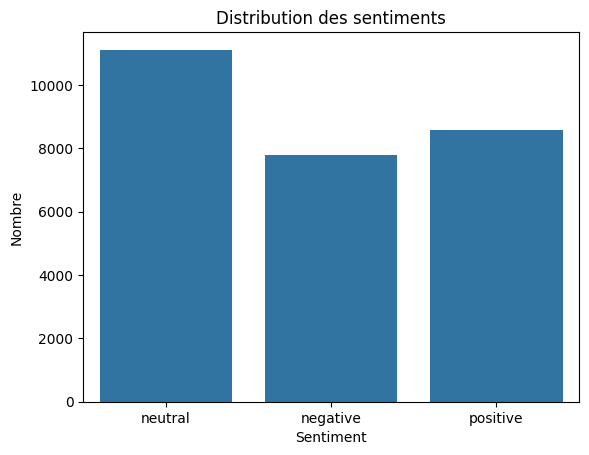

In [ ]:
sns.countplot(x='sentiment', data=train_df)
plt.title("Distribution des sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Nombre")
plt.show()


2. Visualizing Training and Validation Loss Curves

Using PCA

**For n = 1**

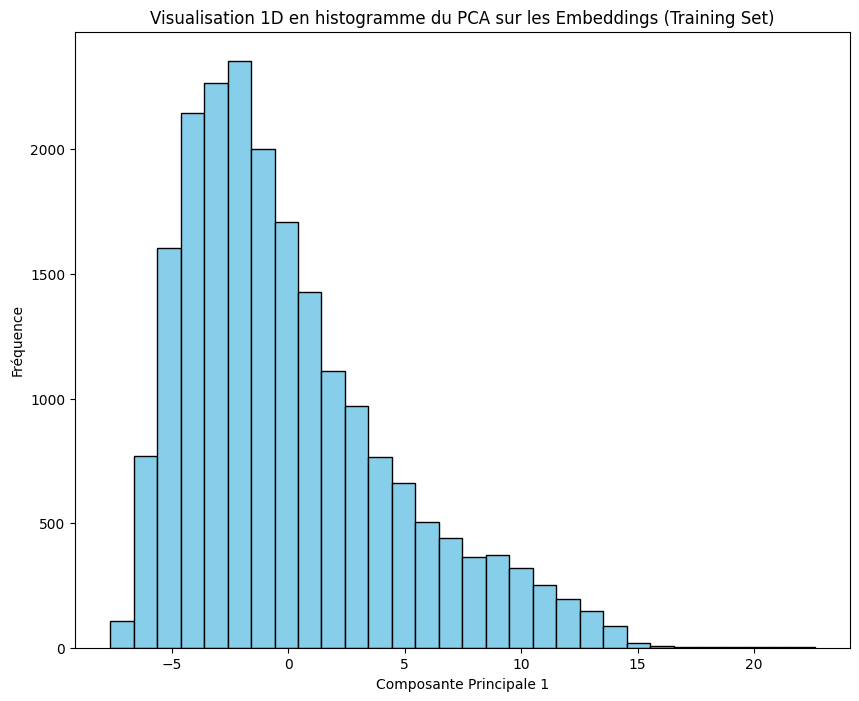

In [ ]:
n_components = 1
pca = PCA(n_components)
train_embeddings_1d = pca.fit_transform(train_embeddings.numpy())

# Visualisation de l'histogramme
plt.figure(figsize=(10, 8))
plt.hist(train_embeddings_1d[:, 0], bins=30, color='skyblue', edgecolor='black')
plt.title("Visualisation 1D en histogramme du PCA sur les Embeddings (Training Set)")
plt.xlabel("Composante Principale 1")
plt.ylabel("Fréquence")
plt.show()


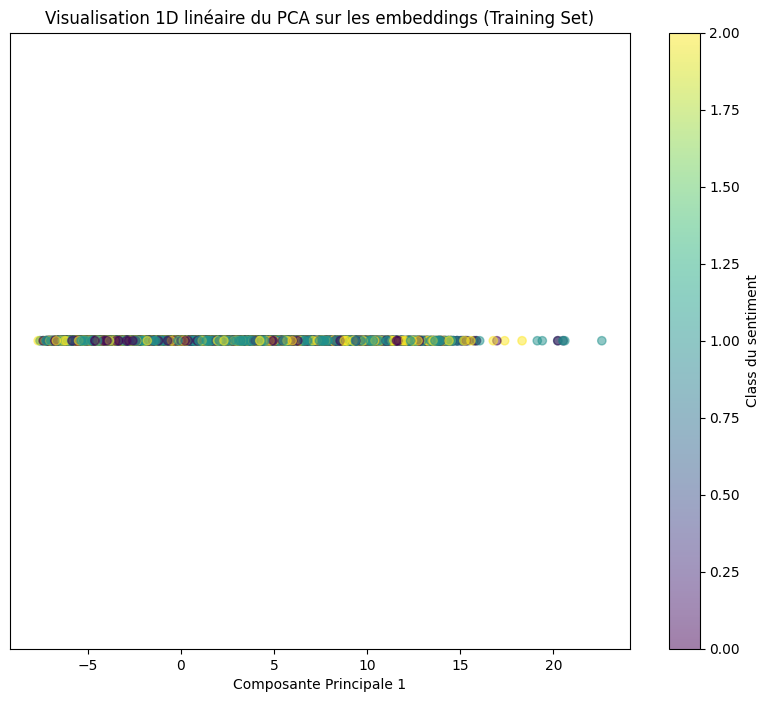

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

y_vals = np.zeros(train_embeddings_1d.shape[0])

# Visualisation en ligne
plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_embeddings_1d[:, 0], y_vals,
                      c=train_y, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Class du sentiment')
plt.title("Visualisation 1D linéaire du PCA sur les embeddings (Training Set)")
plt.xlabel("Composante Principale 1")
plt.yticks([])  # Remove y-axis ticks since they don't represent meaningful information
plt.show()

**For n = 2**

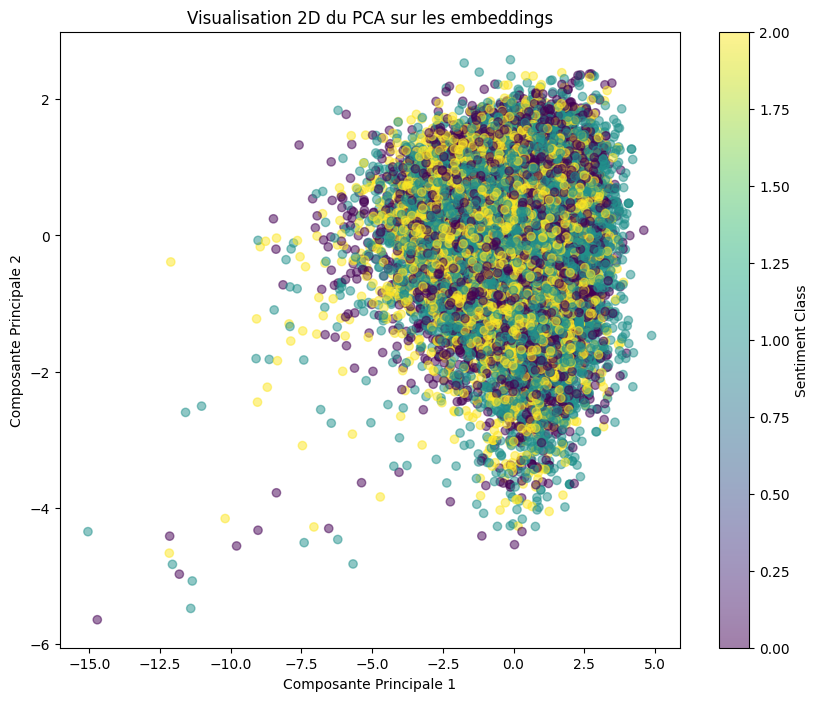

In [ ]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

n_components = 3
pca = PCA(n_components)
# pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)
# pca = KernelPCA(n_components=2, kernel='poly', degree=2)
# pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)
# pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.1)

train_embeddings_2d = pca.fit_transform(train_embeddings.numpy())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_embeddings_2d[:, 0], train_embeddings_2d[:, 1],
                      c=train_y, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Sentiment Class')
plt.title("Visualisation 2D du PCA sur les embeddings")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.show()


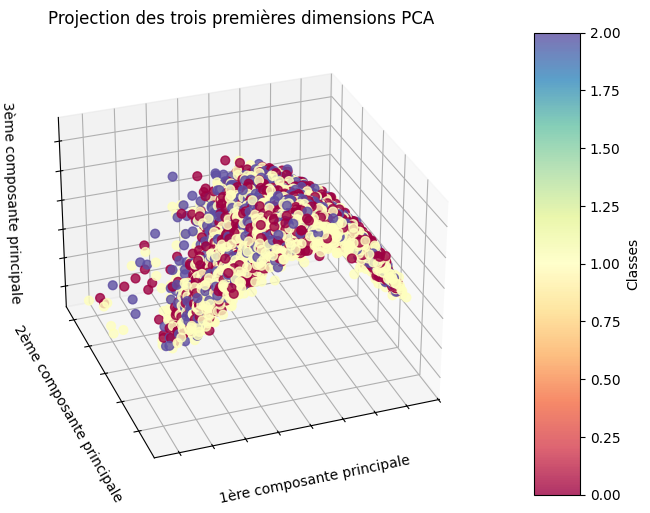

In [ ]:
# Reduce embeddings to 2 dimensions with PCA
pca = KernelPCA(n_components=3, kernel='poly', degree=2) # Most interesting Kernel !!!

train_embeddings_3d = pca.fit_transform(train_embeddings.numpy())


fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

scatter = ax.scatter(
    train_embeddings_3d[:, 0],
    train_embeddings_3d[:, 1],
    train_embeddings_3d[:, 2],
    c=train_y,
    cmap='Spectral',        # Colormap pour mieux distinguer les classes
    s=40,                   # Taille des points
    alpha=0.8               # Transparence légère
)

# Configuration des axes
ax.set(
    title="Projection des trois premières dimensions PCA",
    xlabel="1ère composante principale",
    ylabel="2ème composante principale",
    zlabel="3ème composante principale",
)

# Suppression des labels de ticks pour plus de clarté
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
ax.zaxis.set_ticklabels([])

# Ajout d'une barre de couleurs pour représenter les classes
colorbar = fig.colorbar(scatter, ax=ax, pad=0.1, aspect=10)
colorbar.set_label('Classes')

# Affichage du graphique
plt.show()


In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_

print("Explained Variance Ratio per Component:")
print(explained_variance_ratio)
print("\nExplained Variance per Component:")
print(explained_variance)

print(f"Cumulative explained variance for 3 components: {sum(explained_variance_ratio):.2f}")

Explained Variance Ratio per Component:
[0.69273156 0.10438945]

Explained Variance per Component:
[20.593342   3.1032622]
Cumulative explained variance for 3 components: 0.80


Using t-SNE

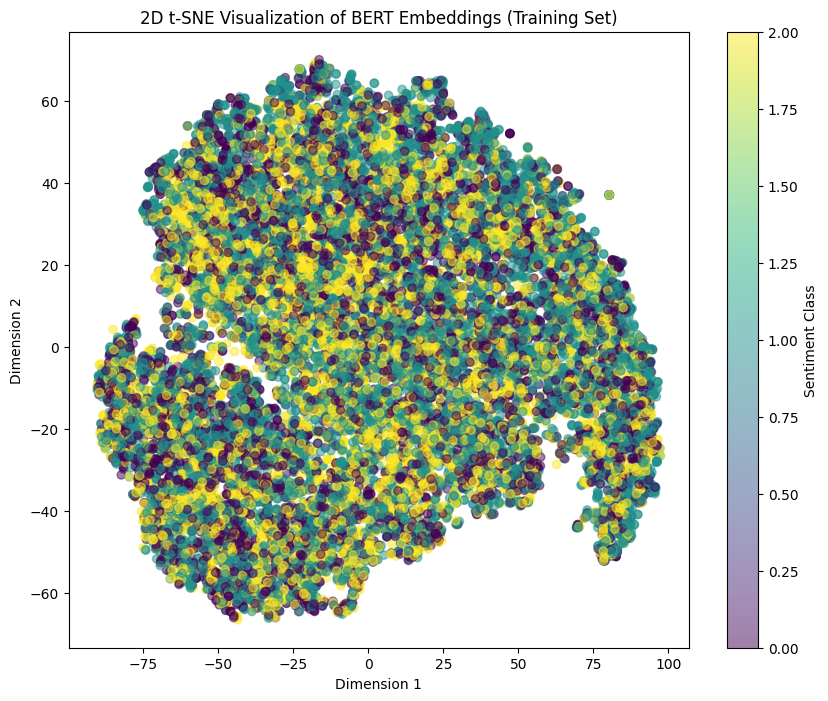

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
train_embeddings_tsne = tsne.fit_transform(train_embeddings.numpy())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(train_embeddings_tsne[:, 0], train_embeddings_tsne[:, 1],
                      c=train_y, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Sentiment Class')
plt.title("2D t-SNE Visualization of BERT Embeddings (Training Set)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()


In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_

print("Explained Variance Ratio per Component:")
print(explained_variance_ratio)
print("\nExplained Variance per Component:")
print(explained_variance)

print(f"Cumulative explained variance for 3 components: {sum(explained_variance_ratio):.2f}")

**Faire un PCA à 95% -> 3-means**

In [ ]:
# PCA avec toutes les composantes
pca = PCA()
train_embeddings_pca = pca.fit_transform(train_embeddings.numpy())
# Variance ratio par composante
explained_variance_ratio = pca.explained_variance_ratio_

cumul_var = 0
i = 0
# On récupère les composantes dont la somme cumulée constitue 95% de la variance
while (cumul_var < 0.95):
    cumul_var += explained_variance_ratio[i]
    i += 1

n_components = i+1
print("Nous devrions avoir {} composantes pour avoir {}% de variance.".format(i+1, int(cumul_var*100)))

Nous devrions avoir 23 composantes pour avoir 95% de variance.


In [ ]:
# Reduce embeddings to 23 dimensions with PCA
print(n_components)
pca = PCA(n_components)

train_embeddings_pca = pca.fit_transform(train_embeddings.numpy())

23


In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_

print("Explained Variance Ratio per Component:")
print(explained_variance_ratio)
print("\nExplained Variance per Component:")
print(explained_variance)

print(f"Cumulative explained variance for 3 components: {sum(explained_variance_ratio):.2f}")

Explained Variance Ratio per Component:
[0.69273156 0.10438945 0.0352178  0.02309251 0.02007595 0.01203258
 0.01042923 0.00811969 0.00682142 0.00531265 0.00430818 0.00391379
 0.00334314 0.00318951 0.00295682 0.00272996 0.00255025 0.00215913
 0.00208065 0.00204379 0.00179613 0.00175866 0.00152435]

Explained Variance per Component:
[20.593342    3.1032622   1.0469453   0.686488    0.5968127   0.35770142
  0.31003737  0.24138017  0.20278552  0.15793316  0.12807232  0.11634817
  0.09938393  0.09481703  0.08789954  0.08115551  0.07581323  0.06418614
  0.06185301  0.06075718  0.0533948   0.05228084  0.04531556]
Cumulative explained variance for 3 components: 0.95


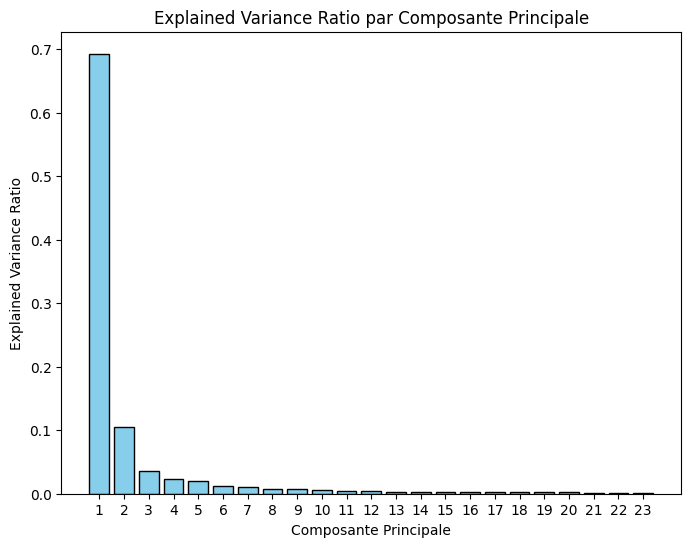

In [ ]:
# Affichage de l'histogramme de la variance
plt.figure(figsize=(8, 6))
components = np.arange(1, n_components + 1)
plt.bar(components, explained_variance_ratio, color='skyblue', edgecolor='black')
plt.xlabel('Composante Principale')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio par Composante Principale')
plt.xticks(components)
plt.show()


### k-means post PCA à n_compo = 23

In [ ]:
# Reduce embeddings to 23 dimensions with PCA
print(n_components)
pca = PCA(n_components)

train_embeddings_pca = pca.fit_transform(train_embeddings.numpy())

23


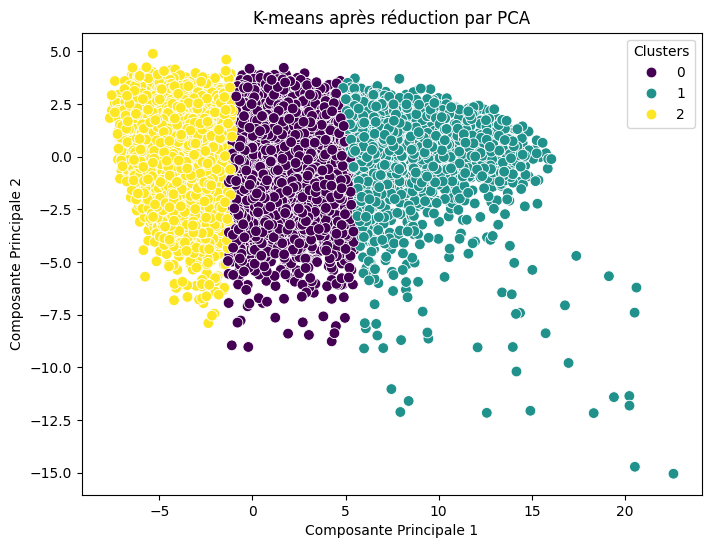

In [ ]:
pca = PCA(n_components)
train_embeddings_pca = pca.fit_transform(train_embeddings.numpy())

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(train_embeddings_pca)

# 3. Visualiser le résultat
plt.figure(figsize=(8,6))
sns.scatterplot(x=train_embeddings_pca[:,0], y=train_embeddings_pca[:,1], hue=clusters, palette="viridis", s=60)
plt.title("K-means après réduction par PCA")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Clusters")
plt.show()

In [ ]:
print(len(clusters))
print(len(train_y))

20610
20610


In [ ]:
def kmeans_accuracy(y_true, y_pred):
    """
    Fonction qui calcule l'accuracy des prédictions sans prendre en compte du
    label. On choisit pour chaque cluster la classe majoritaire pour déterminer
    la prédiction. On compare ensuite avec les vraies étiquettes.
    """
    n = len(y_true)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # labels[i] represente le cluster i. labels[i][j] est le nombre de fois
    # les points dans le cluster i sont classifiés comme j.
    labels = [[0,0,0] for _ in range(3)]
    for i in range(n):
      labels[y_pred[i]][y_true[i]] += 1

    mapping = [np.argmax(labels[i]) for i in range(len(labels))]
    print(mapping)
    print("Le mapping est: {}".format(mapping[0] != mapping[1] != mapping[2]))

    score = 0
    for i in range(n):
      score += (y_true[i] == mapping[y_pred[i]])

    return score/n


In [ ]:
kmeans_accuracy(train_y, clusters)

[1, 1, 1]
Le mapping est: False


0.4041727316836487

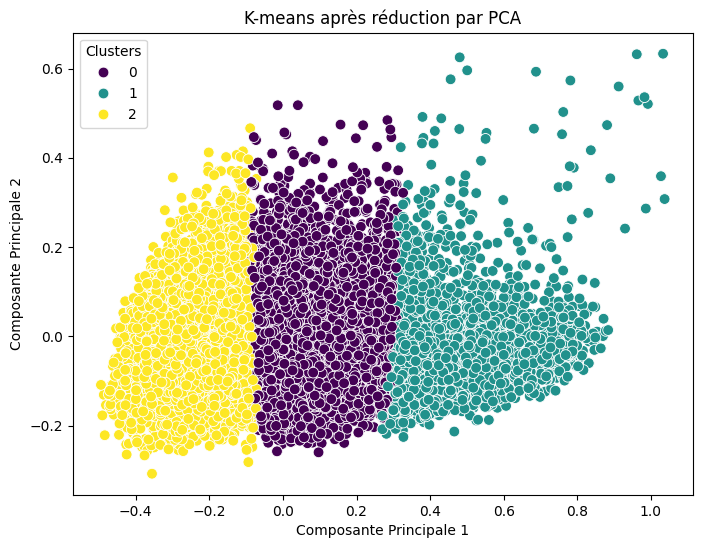

In [ ]:
pca = KernelPCA(n_components=3, kernel='poly', degree=2) # Most interesting Kernel !!!
train_embeddings_pca = pca.fit_transform(train_embeddings.numpy())

k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(train_embeddings_pca)

# 3. Visualiser le résultat
plt.figure(figsize=(8,6))
sns.scatterplot(x=train_embeddings_pca[:,0], y=train_embeddings_pca[:,1], hue=clusters, palette="viridis", s=60)
plt.title("K-means après réduction par PCA")
plt.xlabel("Composante Principale 1")
plt.ylabel("Composante Principale 2")
plt.legend(title="Clusters")
plt.show()

In [ ]:
kmeans_accuracy(train_y, clusters)

[1, 1, 1]
Le mapping est: False


0.4041727316836487

Méthode alternative de calcul de l'accuracy

In [ ]:

def cluster_accuracy(y_true, y_pred):
    """
    Calcule l'accuracy d'un clustering en alignant les étiquettes prédites (y_pred)
    sur les étiquettes réelles (y_true) à l'aide de l'algorithme hongrois.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # On suppose que les labels commencent à 0 et qu'ils vont jusqu'à D-1.
    D = max(y_pred.max(), y_true.max()) + 1
    cost_matrix = np.zeros((D, D), dtype=np.int64)

    for i in range(len(y_pred)):
        cost_matrix[y_pred[i], y_true[i]] += 1

    # On minimise -cost_matrix pour maximiser l'alignement
    row_ind, col_ind = linear_sum_assignment(-cost_matrix)
    mapping = {row: col for row, col in zip(row_ind, col_ind)}

    y_pred_mapped = np.array([mapping[label] for label in y_pred])
    return accuracy_score(y_true, y_pred_mapped)

In [ ]:
cluster_accuracy(train_y, clusters)

# Q1: Predict, ...

In [ ]:

X_train = train_embeddings.cpu().numpy()
X_test = test_embeddings.cpu().numpy()

y_train = np.array(train_y)
y_test = np.array(test_y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


NameError: name 'train_embeddings' is not defined

In [ ]:
class ModelTrainer:
    def __init__(self, model, model_name, **hyperparams):
        self.model_name = model_name
        self.model = model(**hyperparams)
        self.training_time = None
        self.results = {}

    def train(self, X_train, y_train):
        start_time = time.time()
        self.model.fit(X_train, y_train)
        self.training_time = time.time() - start_time

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)

        self.results = {
            'accuracy': acc,
            'report': report,
            'training_time': self.training_time,
            'confusion_matrix': cm,
            'predictions': y_pred
        }

        print(f"--- {self.model_name} ---")
        print(f"Accuracy: {acc:.4f}")
        print(report)
        print(f"Training Time: {self.training_time:.2f} seconds")
        print(f"extreme score: {extreme_score(y_test, y_pred):.2f}")
        print("-" * 50)

        # Plot confusion matrix
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_test), yticklabels=set(y_test))
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title(f'Confusion Matrix - {self.model_name}')
        plt.show()

        return self.results

### Logistic Regression

In [ ]:
parameter = [{'max_iter':50}, {'max_iter':100}, {'max_iter':200}]
for params in parameter:
    trainer = ModelTrainer(LogisticRegression, f"LogisticRegression avec max_iter={params['max_iter']}", **params)
    trainer.train(X_train, y_train)
    trainer.evaluate(X_test, y_test)

### SVM

In [ ]:
parameter = [
    {
        "kernel": "linear"
    },
    {
        "kernel": "poly",
        "degree": 3,
        "gamma": "scale",
        "coef0": 1
    },
    {
        "kernel": "rbf",
        "gamma": "scale"
    },
    {
        "kernel": "sigmoid",
        "gamma": "scale",
        "coef0": 0
    }
]
for params in parameter:
    trainer = ModelTrainer(SVC, f"SVM avec kernel={params['kernel']}", **params)
    trainer.train(X_train, y_train)
    trainer.evaluate(X_test, y_test)

### Random Forest

In [ ]:
parameter = [{'n_estimators':50}, {'n_estimators':100}, {'n_estimators':150}, {'n_estimators':200}]
for params in parameter:
    trainer = ModelTrainer(RandomForestClassifier, f"RandomForestClassifier avec n_estimators={params['n_estimators']}", **params)
    trainer.train(X_train, y_train)
    trainer.evaluate(X_test, y_test)

# Q2 Use a MLP

Hyperparameters

In [ ]:
# Hyperparameters
PRETRAINED_MODEL = "bert-base-uncased"
MAX_LENGTH = 128
BATCH_SIZE = 32
NUM_CLASSES = 3
LEARNING_RATE = 2e-5
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Tokenizer/Embeddings for data

In [ ]:
# Initialize tokenizer, dataset, and dataloader
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL)
traindataset = TextDataset(train_x, train_y, tokenizer, MAX_LENGTH)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=False)
valdataset = TextDataset(val_x, val_y, tokenizer, MAX_LENGTH)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings
train_embeddings = extract_embeddings(bert, trainloader, device)
train_embeddings = train_embeddings.cpu()

val_embeddings = extract_embeddings(bert, valloader, device)
val_embeddings = val_embeddings.cpu()

In [ ]:
pip install torchmetrics

In [ ]:
criterion = nn.CrossEntropyLoss()
# Model Definition
class SentimentClassifier2(nn.Module):
    def __init__(self, hidden_sizes, output_size):
        super(SentimentClassifier2, self).__init__()

        n = len(hidden_sizes)
        self.fc_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        # Fully connected layer for classification
        for i in range(n-1):
          self.fc_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
          self.bn_layers.append(nn.BatchNorm1d(hidden_sizes[i + 1]))

        self.fc_layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Pass through the fully connected layer
        n = len(self.fc_layers)
        for fc, bn in zip(self.fc_layers, self.bn_layers):
            x = fc(x)
            x = bn(x)
            x = F.gelu(x)
            x = self.dropout(x)

        x = self.fc_layers[-1](x)
        return x

# training script

def train(model, train_loader, optimizer, epoch,log_interval=50):
    model.train()
    loss_cpu=0
    correct = 0
    total = 0
    for batch_idx, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, target = data['input_ids'],data['label']
        inputs, target = inputs.cuda(), target.cuda()
        inputs = inputs.detach()
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, target)

        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        loss_cpu += loss.item()
        total += target.size(0)
        correct += predicted.eq(target.data).cpu().sum()

        if batch_idx % log_interval == 0:
            print('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%'
                %(epoch, EPOCHS, batch_idx+1,
                    (len(train_loader)//BATCH_SIZE)+1, loss.item(), 100.*correct/total))
            #n_iter=epoch * len(train_loader) + batch_idx

    return loss_cpu/len(train_loader)

def test(model, test_loader, epoch, plot=False):
    model.eval()
    correct = 0
    total = 0
    test_loss_MSE = 0

    # Initialize F1 metric
    f1_metric = MulticlassF1Score(num_classes=3, average='macro').to(device)

    with torch.no_grad():
        all_preds = []
        all_labels = []

        for batch_idx, data in enumerate(test_loader, 0):
            inputs, target = data['input_ids'], data['label']
            inputs, target = inputs.cuda(), target.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, target)
            test_loss_MSE += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += predicted.eq(target.data).cpu().sum()

            # Collect predictions and labels
            all_preds.append(predicted.cpu())
            all_labels.append(target.cpu())

    # Concatenate predictions and labels
    all_preds = torch.cat(all_preds).numpy()
    all_labels = torch.cat(all_labels).numpy()

    # Calculate F1-score
    f1_score = f1_metric(torch.tensor(all_preds).to(device), torch.tensor(all_labels).to(device))

    # Plot confusion matrix if required
    if plot:
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix - MLP')
        plt.show()

    # Final metrics
    test_loss_MSE = test_loss_MSE / len(test_loader)
    accuracy = 100. * correct / total
    print("\n| Validation Epoch #%d\t\t\tLoss: %.4f Acc@1: %.2f%% F1: %.2f" % (epoch, test_loss_MSE, accuracy, f1_score.item()))

    return test_loss_MSE, accuracy, f1_score.item()

Entraînement

In [ ]:
print ("Let us Train.")

EPOCHS = 40
input_size = len(train_embeddings[0])
output_size = 3
hidden_sizes = [input_size, 512, 128, 16]
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
best_error = float('inf')

model = SentimentClassifier2(hidden_sizes, output_size).to(device)
model_test = SentimentClassifier2(hidden_sizes, output_size).to(device)


from torch.optim.lr_scheduler import ReduceLROnPlateau,StepLR

traindataset = EmbeddingDataset(train_embeddings, train_y)
trainloader = DataLoader(traindataset, batch_size=BATCH_SIZE, shuffle=True)
valdataset = EmbeddingDataset(val_embeddings, val_y)
valloader = DataLoader(valdataset, batch_size=BATCH_SIZE, shuffle=False)


optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
# lr_scheduler =  StepLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = ReduceLROnPlateau(optimizer, 'min', patience=7)

best_error = float('inf')
train_history = []
val_history = []
print('----------------------------------------------------------------------------------------------------')
print('3/ training model 1')
print('----------------------------------------------------------------------------------------------------')

iter =0
for epoch in range(EPOCHS):
    loss = train(model, trainloader, optimizer, epoch)
    train_history.append(loss)

    val_loss, acc, _ = test(model, valloader,epoch)
    val_history.append(val_loss)

    lr_scheduler.step(val_loss)
    print('lr =',get_lr(optimizer))

    if val_loss < best_error:
        best_error=val_loss
        print('Best RMSE is of : ' + str(best_error), 'for epoch :', epoch,'ERROR TEST = ',val_loss)
        #model_test.parameters()=model.state_dict()
        model_test.load_state_dict(model.state_dict(), strict=True)
        torch.save(model_test.state_dict(), "best_model.pth")  # Sauvegarde du modèle


print ("Training Done!")

Let us Train.
----------------------------------------------------------------------------------------------------
3/ training model 1
----------------------------------------------------------------------------------------------------
| Epoch [  0/ 40] Iter[  1/  6]		Loss: 1.0953 Acc@1: 34.375%
| Epoch [  0/ 40] Iter[ 51/  6]		Loss: 1.1323 Acc@1: 35.049%
| Epoch [  0/ 40] Iter[101/  6]		Loss: 1.0297 Acc@1: 39.851%
| Epoch [  0/ 40] Iter[151/  6]		Loss: 0.9967 Acc@1: 42.074%
| Epoch [  0/ 40] Iter[201/  6]		Loss: 1.0124 Acc@1: 44.364%
| Epoch [  0/ 40] Iter[251/  6]		Loss: 0.9834 Acc@1: 45.667%
| Epoch [  0/ 40] Iter[301/  6]		Loss: 0.9906 Acc@1: 46.865%

| Validation Epoch #0			Loss: 1.0187 Acc@1: 46.10% F1: 0.45
lr = 0.0001
Best RMSE is of : 1.0187300780305155 for epoch : 0 ERROR TEST =  1.0187300780305155
| Epoch [  1/ 40] Iter[  1/  6]		Loss: 0.9204 Acc@1: 60.938%
| Epoch [  1/ 40] Iter[ 51/  6]		Loss: 1.0690 Acc@1: 55.300%
| Epoch [  1/ 40] Iter[101/  6]		Loss: 0.9006 Acc@1: 55.55

**Test & Validation**

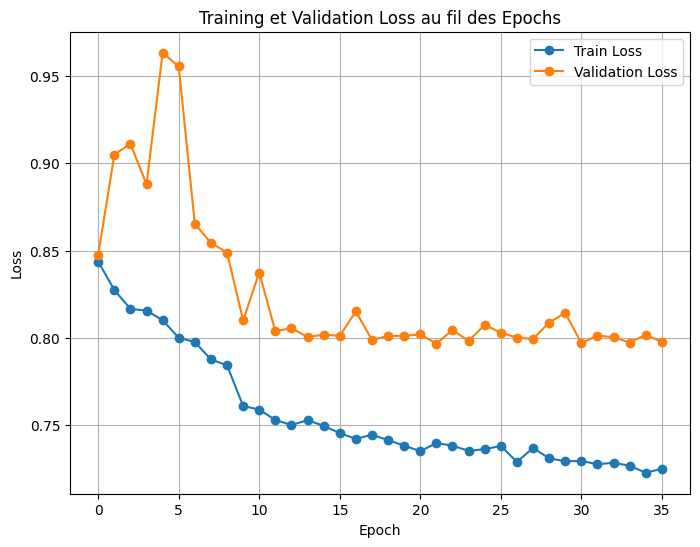

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(train_history[4:], label='Train Loss', marker='o')
plt.plot(val_history[4:], label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training et Validation Loss au fil des Epochs")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
testdataset = TextDataset(test_x,test_y, tokenizer, MAX_LENGTH)
testloader = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)

bert = BertModel.from_pretrained(PRETRAINED_MODEL).to(device)
# Extract embeddings

test_embeddings = extract_embeddings(bert, testloader, device)
test_embeddings = test_embeddings.cpu()

Test set = 


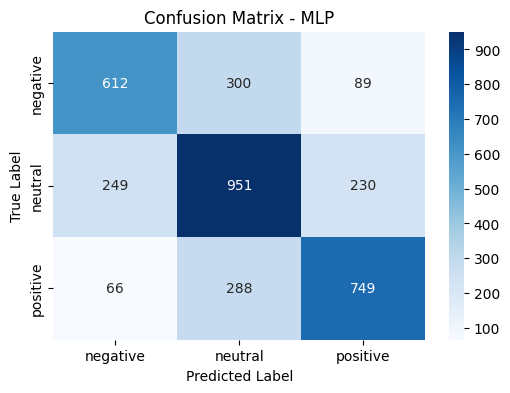


| Validation Epoch #39			Loss: 0.7719 Acc@1: 65.42% F1: 0.66
Test_loss: 0.7718674519232341, Accu: 65.42161560058594, F1-score: 0.6551597118377686, Taux d'erreur critique: ??


In [ ]:
print('==================== ')
print('Test set = ')
testdataset = EmbeddingDataset(test_embeddings, test_y)
testdataset = DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=True)
test_loss, accu, f1 = test(model, testdataset, epoch, True)
print('==================== ')
print("Test_loss: {}, Accu: {}, F1-score: {}, Taux d'erreur critique: ??".format(test_loss, accu, f1))

# Q4: LLM

In [ ]:
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}

# Initialisation d'un llm spécialisé dans la détection de sentiment par un
# pipeline huggingface. Ici on charge roberta
llm_classifier = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment-latest",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment-latest"
)

# Evaluation du llm sur les textes préprocessés
llm_preds = []
for text in test_x:
    result = llm_classifier(text)
    predicted_label = result[0]["label"].lower()
    llm_preds.append(label_mapping[predicted_label])

llm_preds = np.array(llm_preds)
y_test_np = np.array(test_y)

# Calcule la précision du modèle
llm_accuracy = accuracy_score(y_test_np, llm_preds)
llm_report = classification_report(
    y_test_np, llm_preds, target_names=["negative", "neutral", "positive"]
)

print("=== LLM Sentiment Classifier Performance ===")
print("LLM Accuracy: {:.4f}".format(llm_accuracy))
print("\nLLM Classification Report:")
print(llm_report)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=== LLM Sentiment Classifier Performance ===
LLM Accuracy: 0.7043

LLM Classification Report:
              precision    recall  f1-score   support

    negative       0.71      0.72      0.71      1001
     neutral       0.71      0.59      0.65      1430
    positive       0.70      0.84      0.76      1103

    accuracy                           0.70      3534
   macro avg       0.70      0.72      0.71      3534
weighted avg       0.70      0.70      0.70      3534



In [ ]:
model_name = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")
llama_classifier = pipeline("text-generation", model=model, tokenizer=tokenizer)

def classify_sentiment(text):
    prompt = f"Classify the sentiment of the following text as negative, neutral, or positive:\n\n\"{text}\"\n\nSentiment:"
    result = llama_classifier(prompt, max_new_tokens=10, do_sample=False)
    generated_text = result[0]['generated_text']

    output = generated_text[len(prompt):].strip().lower()
    sentiment = output.split()[0]
    if "negative" in sentiment:
        return 0
    elif "neutral" in sentiment:
        return 1
    elif "positive" in sentiment:
        return 2
    else:
        # par défaut, c'est neutre
        return 1

llama_preds = []
for text in test_x:
    pred = classify_sentiment(text)
    llama_preds.append(pred)

llama_preds = np.array(llama_preds)
y_test_np = np.array(test_y)

llama_accuracy = accuracy_score(y_test_np, llama_preds)
llama_report = classification_report(
    y_test_np, llama_preds, target_names=["negative", "neutral", "positive"]
)

print("=== Llama Sentiment Classifier Performance ===")
print("Llama Accuracy: {:.4f}".format(llama_accuracy))
print("\nLlama Classification Report:")
print(llama_report)


OSError: You are trying to access a gated repo.
Make sure to have access to it at https://huggingface.co/meta-llama/Llama-2-7b-chat-hf.
401 Client Error. (Request ID: Root=1-679e9721-797f0ffa14ba70ed4caebc0a;34145c67-61c4-4e6c-baa7-8d01f87cf57f)

Cannot access gated repo for url https://huggingface.co/meta-llama/Llama-2-7b-chat-hf/resolve/main/config.json.
Access to model meta-llama/Llama-2-7b-chat-hf is restricted. You must have access to it and be authenticated to access it. Please log in.

# Q5:

I chose to use BERT embeddings instead of raw text for several important reasons:

1. Rich Contextual Representations:
BERT produces contextualized embeddings, meaning each word’s representation depends on the words around it. This allows the model to capture nuances of meaning, polysemy, and context-specific usage, which raw text or simple bag-of-words representations cannot provide.

2. Pre-trained Language Knowledge:
BERT is pre-trained on massive amounts of data, so its embeddings already encode a significant amount of linguistic, syntactic, and semantic information. This transfer learning capability reduces the need for extensive feature engineering and helps improve performance on downstream tasks like sentiment classification.

3. Dimensionality and Noise Reduction:
Raw text, when converted directly into features (for example, using one-hot encoding or TF-IDF), typically results in very high-dimensional and sparse representations. BERT embeddings, on the other hand, are dense and lower-dimensional vectors that compactly capture the essence of the text, making them more suitable for most machine learning algorithms.

4. Improved Generalization:
Using BERT embeddings helps the classifier generalize better to unseen data because the embeddings capture robust semantic patterns. This means the model can learn to focus on the sentiment-relevant features of the text without being overwhelmed by irrelevant variations present in the raw text.

5. Ease of Integration with Modern Models:
BERT embeddings serve as a powerful input to both classical machine learning models and deep learning architectures. They provide a standardized way to represent text data, which can then be fed into various classifiers (such as logistic regression, SVMs, or MLPs) to achieve better performance on sentiment analysis tasks.

In summary, by using BERT embeddings, I leverage the state-of-the-art understanding of language that BERT has acquired during pre-training. This results in richer, more informative features compared to raw text, ultimately leading to improved accuracy and efficiency in sentiment classification.

# Q6: Transformers

BERT (Bidirectional Encoder Representations from Transformers) is a deep learning model designed to generate contextualized word embeddings. Its architecture builds on the Transformer encoder, which is renowned for its self-attention mechanism. Here’s a detailed breakdown of its architecture:

1. Input Representation:

- Token Embeddings:
Each word (or subword, using WordPiece tokenization) is converted into a vector. Unlike traditional embeddings that are static, these token embeddings are learned during pre-training and fine-tuning.

- Segment Embeddings:
When BERT processes a pair of sentences (for tasks like next sentence prediction), each token is tagged with a segment embedding (e.g., Segment A or Segment B) to indicate which sentence it belongs to.

- Positional Embeddings:
Since the Transformer architecture doesn’t inherently understand word order, positional embeddings are added to encode the position of each token within the sequence.

These three types of embeddings are summed to form a single input vector for each token.

2. Transformer Encoder Blocks:

BERT is composed solely of Transformer encoder layers (e.g., 12 layers in BERT-Base, 24 in BERT-Large). Each encoder block consists of:

- Multi-Head Self-Attention:
This mechanism allows each token to attend to every other token in the sequence, capturing bidirectional context. Instead of computing one single attention score, the multi-head approach computes multiple attention distributions (heads) in parallel, enabling the model to learn different aspects of the relationships between tokens.

- Feed-Forward Neural Network:
After the self-attention layer, each token’s representation is passed through a fully connected feed-forward network (typically two linear layers with a non-linear activation, such as GELU) independently. This step helps in learning higher-level representations.

- Residual Connections and Layer Normalization:
Each sub-layer (both the self-attention and the feed-forward network) is wrapped with residual (skip) connections and layer normalization. This design stabilizes training and allows for deeper networks by facilitating better gradient flow.

3. Pre-training Objectives:

BERT is pre-trained on large corpora with two novel unsupervised tasks:

- Masked Language Modeling (MLM):
A certain percentage of the input tokens (e.g., 15%) are randomly masked, and the model is trained to predict these masked tokens using the surrounding context. This forces the model to develop a deep understanding of language context in both directions.

- Next Sentence Prediction (NSP):
The model is given pairs of sentences and trained to predict whether the second sentence logically follows the first. This objective helps the model understand relationships between sentences, which is beneficial for tasks like question answering and natural language inference.

4. Output Representation:

- [CLS] Token:
BERT prepends a special classification token, [CLS], to every input sequence. The final hidden state corresponding to this token is used as an aggregate representation of the whole sequence and is often employed for classification tasks.

- Contextualized Embeddings:
Beyond the [CLS] token, each token in the sequence obtains a contextualized representation, meaning that its final embedding captures both its own identity and its contextual usage based on all other tokens in the sequence.

5. Bidirectionality:

One of BERT’s key innovations is its fully bidirectional architecture. By attending to both left and right contexts simultaneously (thanks to the Transformer’s self-attention), BERT can capture richer semantic relationships than models that process text in a strictly left-to-right manner.

**In Summary:**

BERT’s architecture consists of stacked Transformer encoder layers that operate on a combined input of token, segment, and positional embeddings. Its multi-head self-attention mechanism enables the model to capture complex, bidirectional relationships within the text, while pre-training tasks like Masked Language Modeling and Next Sentence Prediction allow it to build a deep, contextual understanding of language. This architecture has proven highly effective for a wide range of NLP tasks, making BERT one of the foundational models in modern natural language processing.

# Q7: LoRA & Fine-Tuning

In [1]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

train_dataset = SentimentDataset(train_x, train_y, tokenizer)
val_dataset = SentimentDataset(val_x, val_y, tokenizer)
test_dataset = SentimentDataset(test_x, test_y, tokenizer)

training_args = TrainingArguments(
    output_dir="./lora_roberta_sentiment",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


start_time = time.time()
trainer.train()
training_time = time.time() - start_time
print(f"\nTraining completed in {training_time:.2f} seconds")

NameError: name 'SentimentDataset' is not defined

In [ ]:

eval_results = trainer.evaluate()
print("\n--- Résultats de l'évaluation ---")
print(eval_results)

preds_output = trainer.predict(val_dataset)
predictions = np.argmax(preds_output.predictions, axis=-1)

accuracy = accuracy_score(val_y, predictions)
report = classification_report(val_y, predictions, target_names=["négatif", "neutre", "positif"])
cm = confusion_matrix(val_y, predictions)

print("\n--- Rapport de classification ---")
print(report)
print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["négatif", "neutre", "positif"],
            yticklabels=["négatif", "neutre", "positif"])
plt.xlabel("Prédiction")
plt.ylabel("Réel")
plt.title("Matrice de confusion - RoBERTa avec LoRA")
plt.show()
